In [1]:
from __future__ import print_function
import copy
# import cProfile, pstats, StringIO
import iminuit
# %load_ext ipycache
%load_ext line_profiler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from multiprocessing import Pool
import numba
import numpy as np
import os
import pandas as pd
import pymp
import random
import scipy as sp
from scipy import optimize
from scipy import stats
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
import c14_models

In [3]:
def CI(M, p):
    value = M.values[p]
    lower = M.get_merrors()[p]['lower']
    upper = M.get_merrors()[p]['upper']
    return value + lower, value + upper

In [4]:
C14_atm = np.vectorize(c14_models.C_atm)

In [5]:
c14_patient_data = pd.read_pickle('./data/C14data_liver_samples_20180505.pkl').query('valid')

In [6]:
c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,error_measurement,N_cells,pathology,subject_age,valid
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,73.583333,True
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,25.416667,True
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,0.008788,58.0,N,31.250000,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,0.005342,52.0,N,34.416667,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,58.333333,True


In [7]:
hepatocyte_data = c14_patient_data.query('valid and type in ["hepatocyte", "hepatocyte 2n", "hepatocyte 4n"]')
hepatocyte_data.describe()

,Dbirth,Dcoll,d14C,error_measurement,N_cells,subject_age
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,1962.171717,2016.330808,0.038511,0.006863,72.651515,54.159091
std,20.123360,2.990471,0.018763,0.002568,27.201931,19.753333
min,1932.583333,2004.833333,0.005100,0.004050,21.500000,20.000000
25%,1945.833333,2016.666667,0.027700,0.004650,56.000000,36.000000
50%,1959.333333,2017.166667,0.032800,0.005350,67.000000,58.166667
75%,1980.416667,2017.416667,0.046900,0.009000,96.000000,69.333333
max,1997.333333,2017.500000,0.090351,0.011659,129.000000,84.583333


# EDA

## Atmospheric 14C

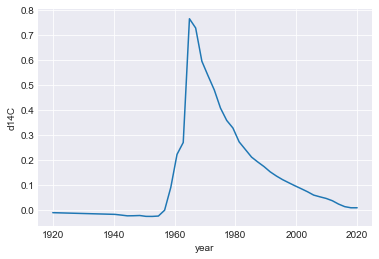

In [8]:
plt.figure()
tt = np.linspace(1920, 2020)
plt.plot(tt, C14_atm(tt))
plt.xlabel('year')
plt.ylabel('d14C')
plt.show()

## Patient data

In [9]:
sns.set_context('talk')

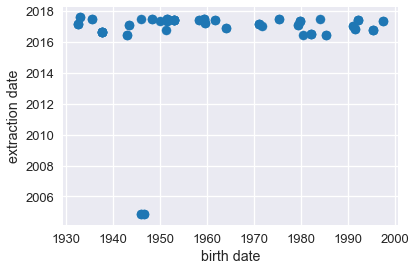

In [10]:
plt.figure()
plt.scatter(c14_patient_data['Dbirth'], c14_patient_data['Dcoll'])
plt.xlabel('birth date')
plt.ylabel('extraction date')
plt.savefig('plots/sample_dates.svg', bbox_inches='tight')
plt.show()

### Hepatocyte data

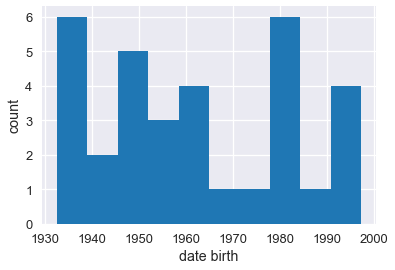

In [11]:
plt.figure()
plt.hist(hepatocyte_data['Dbirth'])
plt.xlabel('date birth')
plt.ylabel('count')
plt.show()

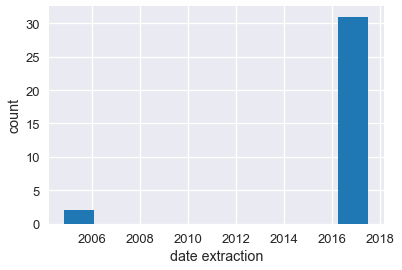

In [12]:
plt.figure()
plt.hist(hepatocyte_data['Dcoll'])
plt.xlabel('date extraction')
plt.ylabel('count')
plt.show()

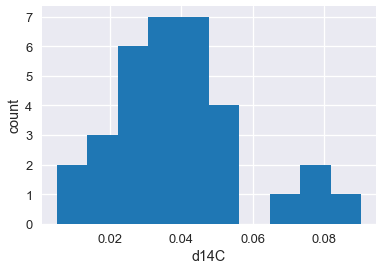

In [13]:
plt.figure()
plt.hist(hepatocyte_data['d14C'])
plt.xlabel('d14C')
plt.ylabel('count')
plt.show()

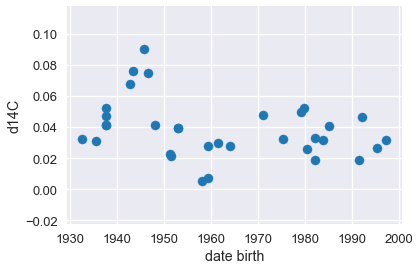

In [14]:
plt.figure()
plt.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'])
plt.xlabel('date birth')
plt.ylabel('d14C')
plt.show()

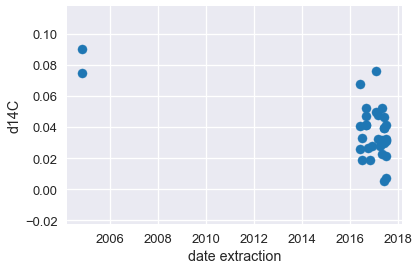

In [15]:
plt.figure()
plt.scatter(hepatocyte_data['Dcoll'], hepatocyte_data['d14C'])
plt.xlabel('date extraction')
plt.ylabel('d14C')
plt.show()

## Correlations

### atmospheric 14C at patient dates and 14C DNA concentration

Define helper function to get atmospheric 14C at given date

In [16]:
C14_atm(2000)

array(0.09405)

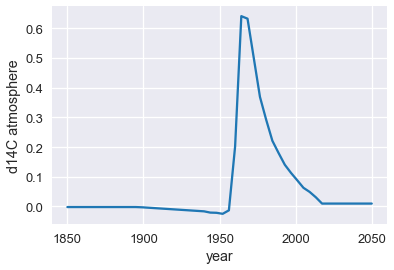

In [17]:
plt.figure()
time = sp.linspace(1850, 2050)
plt.plot(time, C14_atm(time))
plt.xlabel('year')
plt.ylabel('d14C atmosphere')
plt.show()

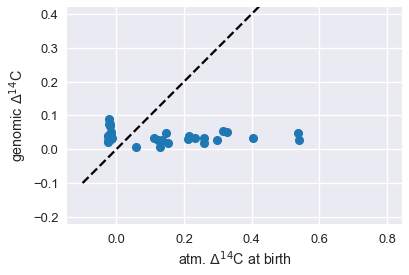

In [18]:
plt.plot(C14_atm(hepatocyte_data['Dbirth']), hepatocyte_data['d14C'], ls='None',marker='o')
x = sp.linspace(-0.1, 0.8)
plt.plot(x, x, 'k--')
plt.xlabel('atm. $\Delta^{14}$C at birth')
plt.ylabel('genomic $\Delta^{14}$C')
plt.axis('equal')
plt.ylim(0, 0.2)
plt.savefig('plots/correlation_birth_gene.svg', bbox_inches='tight')
plt.show()

In [19]:
sp.stats.pearsonr(C14_atm(hepatocyte_data['Dbirth']), hepatocyte_data['d14C'])

(-0.22518297223725958, 0.20768508419057197)

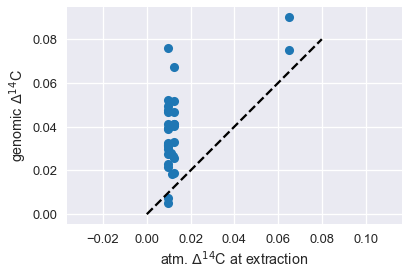

In [20]:
plt.plot(C14_atm(hepatocyte_data['Dcoll']), hepatocyte_data['d14C'], ls='None',marker='o')
x = sp.linspace(0, 0.08)
plt.plot(x, x, 'k--')
plt.xlabel('atm. $\Delta^{14}$C at extraction')
plt.ylabel('genomic $\Delta^{14}$C')
plt.axis('equal')
plt.savefig('plots/correlation_extraction_gene.svg', bbox_inches='tight')
plt.show()

In [21]:
sp.stats.pearsonr(C14_atm(hepatocyte_data['Dcoll']), 
            hepatocyte_data['d14C'])

(0.613835804986657, 0.00014515569467941068)

Only where atmospheric 14C data available:

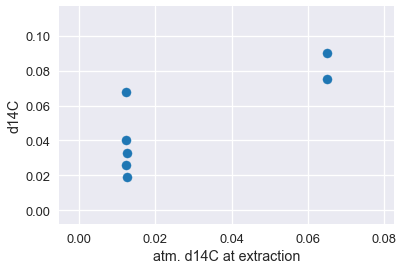

In [22]:
plot_data = hepatocyte_data.query('Dcoll < 2016.6')
plt.scatter(C14_atm(plot_data['Dcoll']), 
            plot_data['d14C'])
plt.xlabel('atm. d14C at extraction')
plt.ylabel('d14C')
plt.show()

In [23]:
sp.stats.pearsonr(C14_atm(plot_data['Dcoll']), 
            plot_data['d14C'])

(0.8111595013465448, 0.026808977947463637)

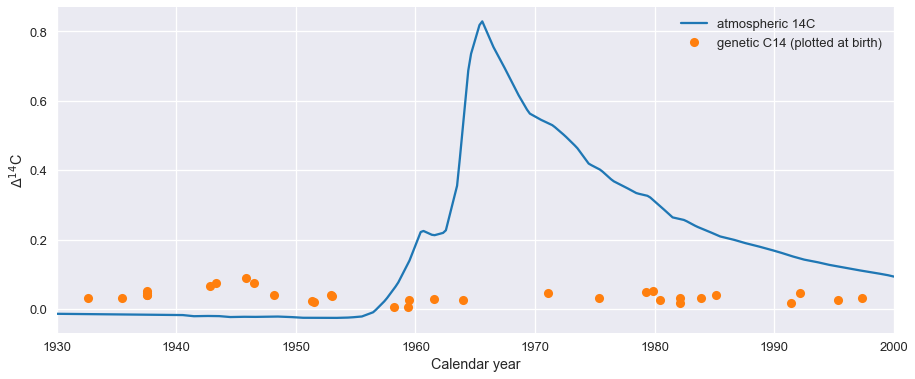

In [24]:
plt.figure( figsize=(15, 6) )
time = sp.linspace(1930, 2000, 300)
plt.plot(time, C14_atm(time), label='atmospheric 14C')

plt.plot(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], ls='None', marker='o', 
         label='genetic C14 (plotted at birth)')

plt.xlim(1930, 2000)
#plt.ylim(0, 0.1)

plt.xlabel('Calendar year')
plt.ylabel('$\Delta^{14}$C')

plt.legend(loc='best')

plt.savefig('plots/C14_at_birth.svg', bbox_inches='tight')
plt.savefig('plots/C14_at_birth.png', bbox_inches='tight', dpi=300)

plt.show()

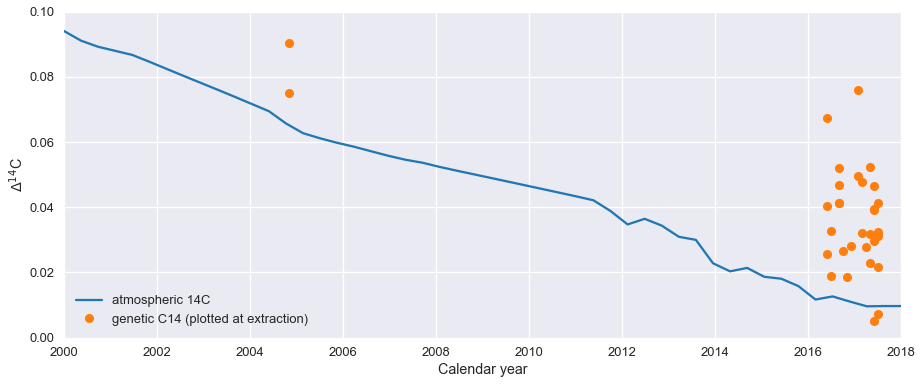

In [25]:
plt.figure( figsize=(15, 6) )
time = sp.linspace(2000, 2018)
plt.plot(time, C14_atm(time), label='atmospheric 14C')

plt.plot(hepatocyte_data['Dcoll'], hepatocyte_data['d14C'], ls='None', marker='o', 
         label='genetic C14 (plotted at extraction)')

plt.xlim(2000, 2018)
plt.ylim(0, 0.1)

plt.xlabel('Calendar year')
plt.ylabel('$\Delta^{14}$C')

plt.legend(loc='lower left')

plt.savefig('plots/C14_at_coll.svg', bbox_inches='tight')

plt.show()

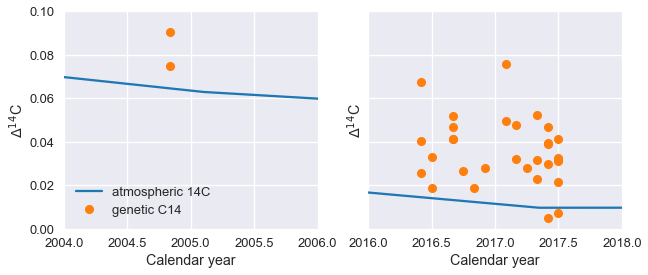

In [26]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

for ax in axs:
    time = sp.linspace(1850, 2050)
    ax.plot(time, C14_atm(time), label='atmospheric 14C')

    ax.plot(hepatocyte_data['Dcoll'], hepatocyte_data['d14C'], ls='None', marker='o', label='genetic C14')

    ax.set_ylim(0, 0.1)

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()

axs[0].set_xlim(2004, 2006)
axs[1].set_xlim(2016, 2018)
    
plt.savefig('plots/C14_at_coll.svg', bbox_inches='tight')

plt.show()

#### What is the most important date for your liver?

Idea: calcululate correlation coefficient between liver C14 concentration and atm. C14 concentration at different years during your live.

### Correlation to sample size

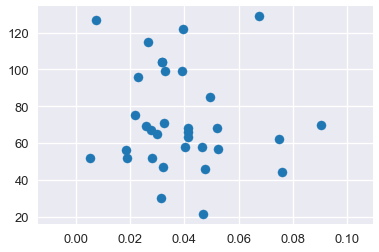

In [27]:
plt.scatter(hepatocyte_data['d14C'], hepatocyte_data['N_cells'])
plt.show()

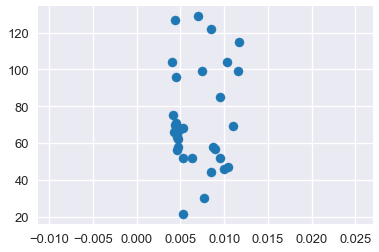

In [28]:
plt.scatter(hepatocyte_data['error_measurement'], hepatocyte_data['N_cells'])
plt.show()

### Date after birth

In [29]:
@np.vectorize
def pearsonr_birth(t, p_max = 0.05):
    data = hepatocyte_data.query('Dbirth + @t < Dcoll') 
    if len(data) < 10:
        return np.nan
    r, p = sp.stats.pearsonr(data['d14C'], 
                             C14_atm(data['Dbirth']+t)
                             )
    if p<p_max:
        return r
    else:
        return np.nan

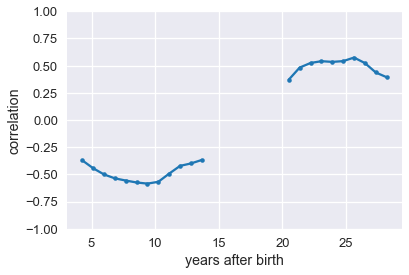

In [30]:
tt = np.linspace(0, max(hepatocyte_data['Dcoll']-hepatocyte_data['Dbirth']), 100)
plt.plot(tt, pearsonr_birth(tt, p_max=0.05), marker='.')
plt.ylim(-1, 1)

plt.xlabel('years after birth')
plt.ylabel('correlation')

plt.show()

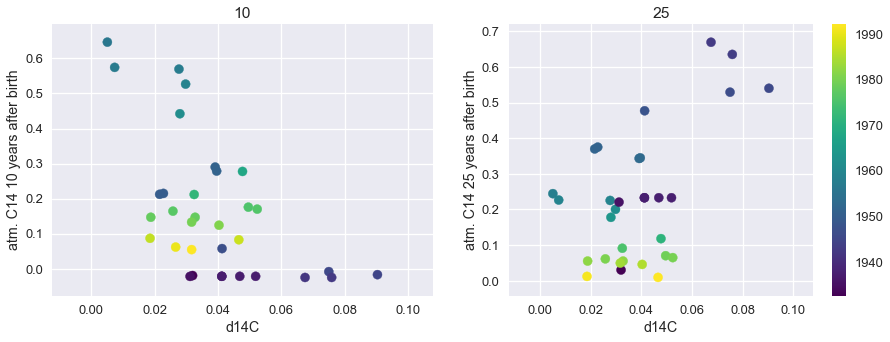

In [31]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

cmap = plt.cm.get_cmap('viridis')

for ax, t in zip(axs, [10, 25]):
    data = hepatocyte_data.query('Dbirth < Dcoll - @t') 
    sc = ax.scatter(data['d14C'], C14_atm(data['Dbirth']+t), 
           c=data['Dbirth'], cmap=cmap)
    ax.set_xlabel('d14C')
    ax.set_ylabel('atm. C14 {0} years after birth'.format(t))
    ax.set_title(t)
plt.colorbar(sc)
plt.show()

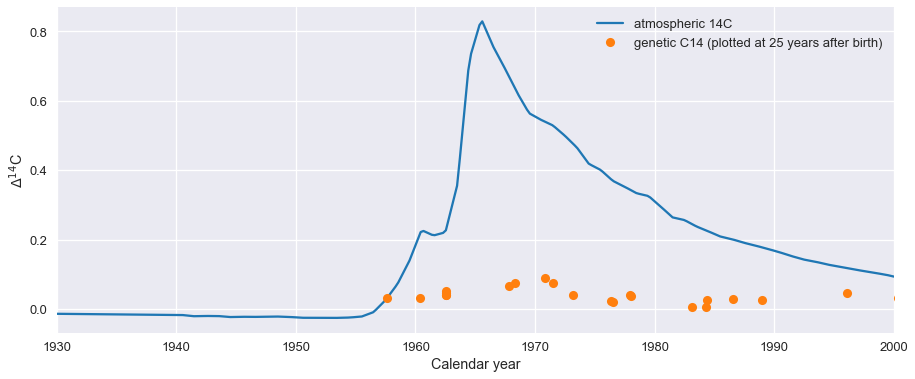

In [32]:
plt.figure( figsize=(15, 6) )
time = sp.linspace(1930, 2000, 300)
plt.plot(time, C14_atm(time), label='atmospheric 14C')

plt.plot(hepatocyte_data['Dbirth']+25, hepatocyte_data['d14C'], ls='None', marker='o', 
         label='genetic C14 (plotted at 25 years after birth)')

plt.xlim(1930, 2000)
#plt.ylim(0, 0.1)

plt.xlabel('Calendar year')
plt.ylabel('$\Delta^{14}$C')

plt.legend(loc='best')

plt.savefig('plots/C14_at_birth.svg', bbox_inches='tight')
plt.savefig('plots/C14_at_birth.png', bbox_inches='tight', dpi=300)

plt.show()

### Date before collection

We need to be very carefull in interpreting this plot because we effectively have only 2 dates of collection.

In [33]:
@np.vectorize
def pearsonr_coll(t, p_max = 0.05):
    data = hepatocyte_data.query('Dbirth < Dcoll - @t') 
    if len(data) < 10:
        return np.nan
    r, p = sp.stats.pearsonr(C14_atm(data['Dcoll']-t), 
                             data['d14C'])
    if p<p_max:
        return r
    else:
        return np.nan

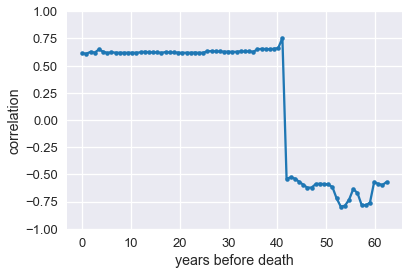

In [34]:
tt = np.linspace(0, max(hepatocyte_data['Dcoll']-hepatocyte_data['Dbirth']), 100)
plt.plot(tt, pearsonr_coll(tt, p_max=0.05), marker='.')
plt.ylim(-1, 1)

plt.xlabel('years before death')
plt.ylabel('correlation')

plt.show()

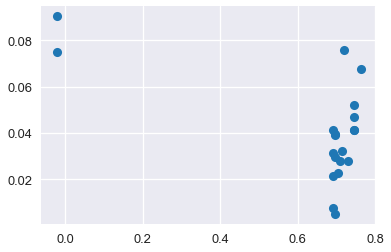

In [35]:
t = 50
data = hepatocyte_data.query('Dbirth < Dcoll - @t') 

plt.plot(C14_atm(data['Dcoll']-t), data['d14C'], ls='None',marker='o')
plt.show()